<a href="https://colab.research.google.com/github/dani-jimlar/XAI_AIPI_590/blob/main/XAI_assignment_7_Explainable_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1
!pip install torch torchvision scipy opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
 

#AIPI 590 - XAI | Assignment 6
##Explainable Deep Learning
##Daniela Jiménez Lara

## Explainable Feature Attribution with saliency maps.

Saliency maps are a gradient based feature attribution method, where we compute the gradient of the predicition (classification score) with respect to input features. This vanilla gradient provides pixel-level importance.

Process: Calculate the gradient of the loss function for the class of interest with respect to the input pixels.

Steps:

*   Forward pass image of interest
*   Compute the gradient of the class score of interest with respect to pixels (set all other clasess to zero)
*   Visualize the gradients (show absolute values or highlight postive and negative contributions)

**Saturation Problem**: when activation goes below zero, it gets stuck -> During backporpagation the gradient flowing through this neuron will be zero.(indicating no changes needed in the weights connected to this neuron).  











# Hypotheses testing
## H0 (null).
Pixels highlighting the silhoutte of cats from images in ResNet model are not more important compared to the pixels within the cat.

## H1 (alternative)
Pixels highlighting the silhoutte of cats from images in ResNet model are more important compared to the pixels within the cat.




# Experiments

In [2]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import stats


In [3]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
cat_indices = [i for i, (_, label) in enumerate(testset) if label == 3]
cat_subset = torch.utils.data.Subset(testset, cat_indices)
testloader = torch.utils.data.DataLoader(cat_subset, batch_size=1, shuffle=False)


model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Define functions for gradient computation

#  generate saliency map
def generate_saliency_map(model, input_image):
    input_image = input_image.to(device)
    input_image.requires_grad_()

    output = model(input_image)

    # cats: class, index 3
    score = output[0, 3]

    # backward pass
    model.zero_grad()
    score.backward()

    # gradients and compute magnitude
    saliency_map = input_image.grad.data.abs()
    saliency_map, _ = torch.max(saliency_map, dim=1)
    saliency_map = saliency_map.squeeze().cpu().numpy()

    # normalize
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    return saliency_map

#  get cat segmentation masks
def get_cat_segmentation(image):
    image_uint8 = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

    # apply adaptive thresholding
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

    # edges
    edges = cv2.Canny(gray, 100, 200)

    # boundary region
    kernel = np.ones((3,3), np.uint8)
    boundary = cv2.dilate(edges, kernel, iterations=1)

    #  masks
    boundary_mask = (boundary > 0).astype(float)
    internal_mask = (~boundary.astype(bool) & (binary < 127)).astype(float)

    return boundary_mask, internal_mask


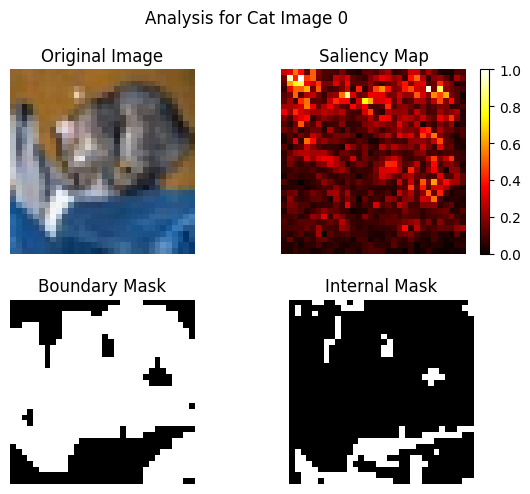

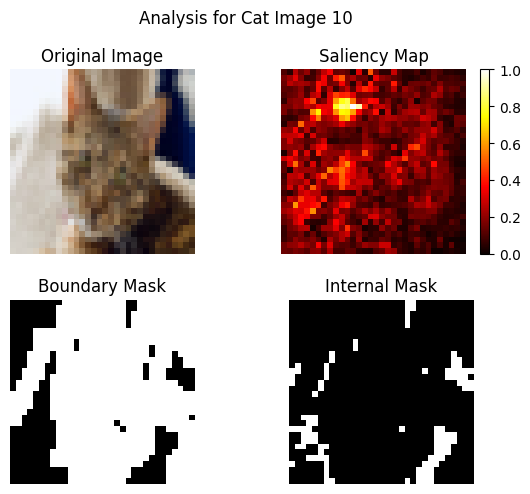

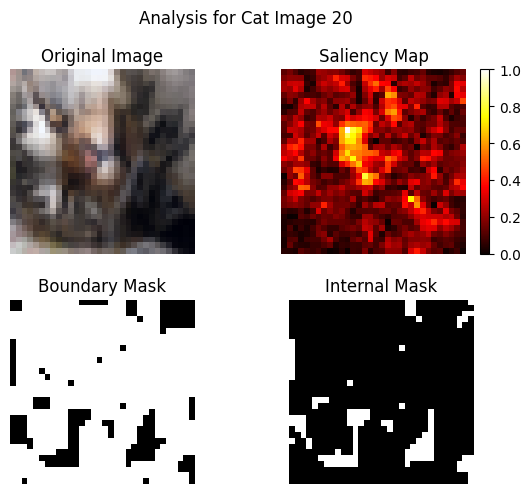

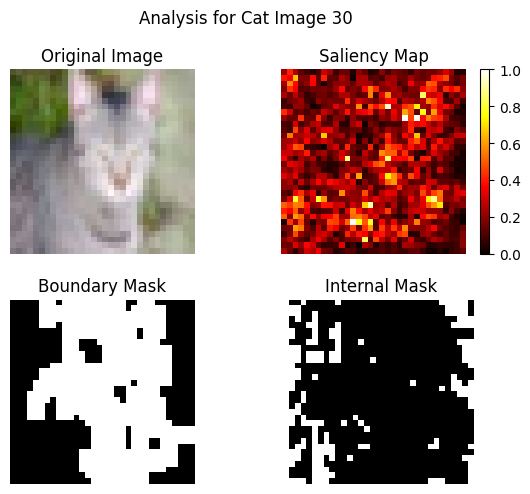

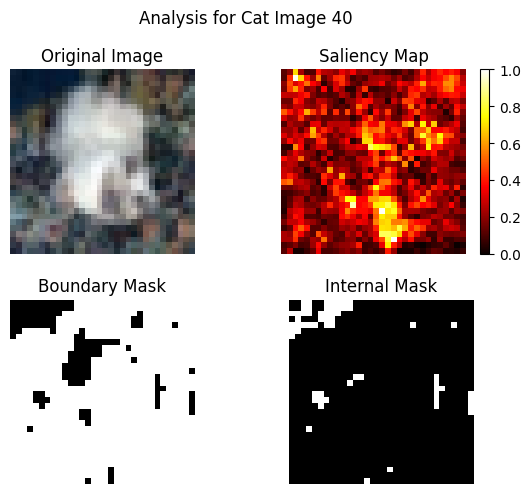

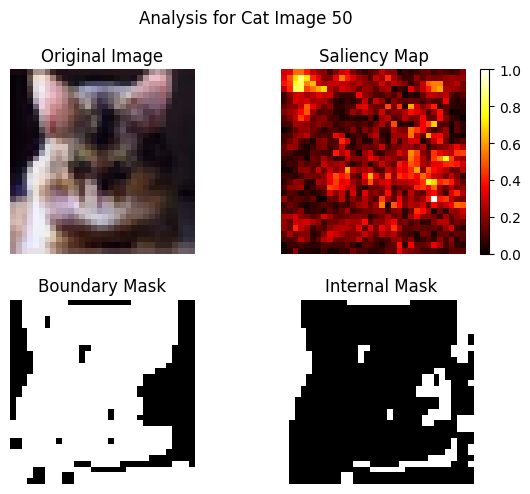

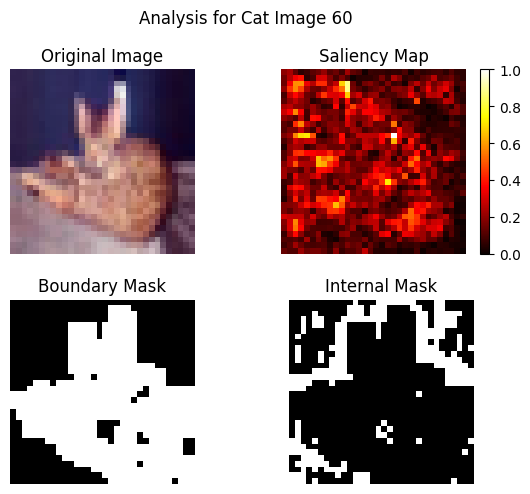

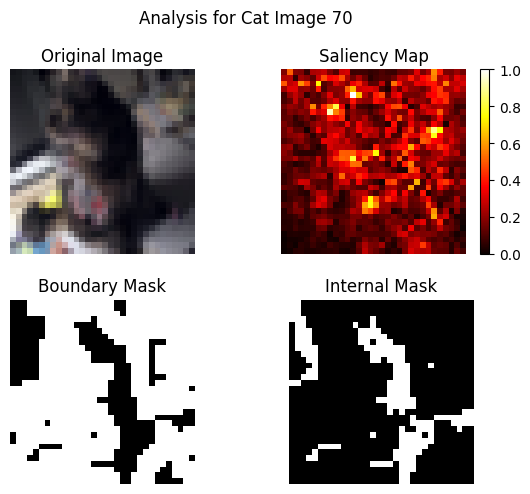

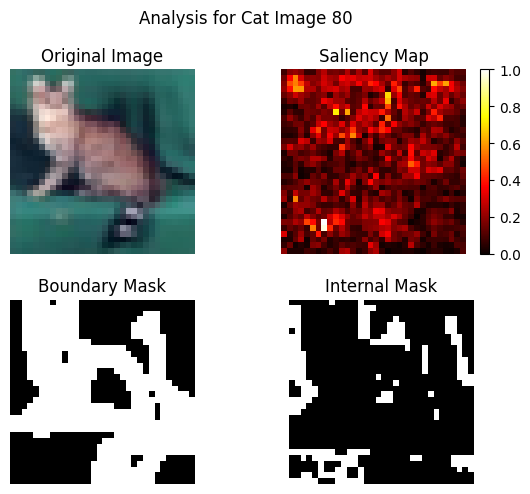

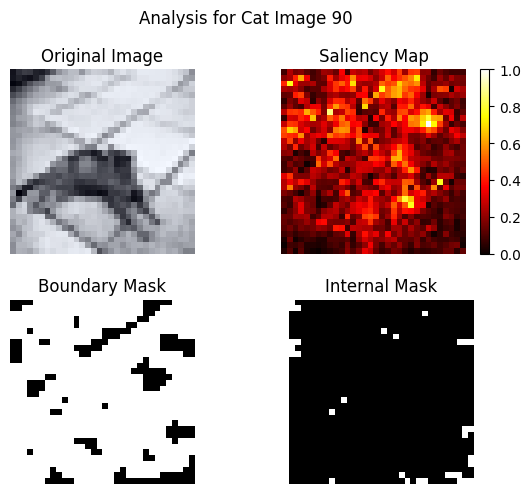

In [6]:

# lists to store importance values
boundary_importances = []
internal_importances = []

# images output
sample_size = min(100, len(cat_subset))

for i, (images, labels) in enumerate(testloader):
    if i >= sample_size:
        break

    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # saliency map
    saliency = generate_saliency_map(model, images)

    # masks
    boundary_mask, internal_mask = get_cat_segmentation(image)

    # mean saliency values
    boundary_saliency = np.mean(saliency * boundary_mask)
    internal_saliency = np.mean(saliency * internal_mask)

    boundary_importances.append(boundary_saliency)
    internal_importances.append(internal_saliency)

    # print images
    if i % 10 == 0:
        fig, axes = plt.subplots(2, 2, figsize=(6, 5))
        fig.suptitle(f'Analysis for Cat Image {i}')

        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Original Image')

        im = axes[0, 1].imshow(saliency, cmap='hot')
        axes[0, 1].set_title('Saliency Map')
        plt.colorbar(im, ax=axes[0, 1])

        axes[1, 0].imshow(boundary_mask, cmap='gray')
        axes[1, 0].set_title('Boundary Mask')

        axes[1, 1].imshow(internal_mask, cmap='gray')
        axes[1, 1].set_title('Internal Mask')

        for ax in axes.flat:
            ax.axis('off')

        plt.tight_layout()
        plt.show()




# Summary of findings

In [9]:
boundary_imp = np.array(boundary_importances)
internal_imp = np.array(internal_importances)

t_stat, p_value = stats.ttest_rel(boundary_imp, internal_imp)


In [10]:

print(f"\nHypothesis Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")



Hypothesis Test Results:
T-statistic: 22.5000
P-value: 0.0000


The p-vlaue from the statistical analysis lets us reject the null hypothesis and confirm that boundary pixels are more important than internal pixels when classifying cat images in the Resnet model. The postive  T-statstic value indicates a strong effect of the importance of boundary pixels vs internal pixels. The experiment suggests that the silhouette of a cat is more important than the characteristics of the cat for classifiyng images.

### Code development assisted with Claude 3.5 Sonnet